In [3]:
import sys; sys.path.append("../../wwa"); from wwa import *

mapproj = cartopy.crs.PlateCarree()

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/"

Xn,Xx,Yn,Yx = [0,35,55,75]
xn,xx,yn,yx = [4,30,60,72]

In [ ]:
sf = gpd.read_file(fpath+"sf_sweden-adm1")
norrland = sf.iloc[[0,1,2,6,7]].dissolve()
norrland.to_file(fpath+"sf_norrland")

# Coordinates of sites where records were observed

In [ ]:
# # locations of records
# sites = pd.read_csv("fs-heat-records.csv", index_col = "Site")
# px = pd.DataFrame.from_dict({k : get_latlon(k+", "+r.Country) for k,r in sites.iterrows()}).transpose()

# sites = merge_byindex([sites, px])
# sites.to_csv("fs-heat-records_with-coords.csv")

In [ ]:
# list of names that were updated manually from the original reported list
# corrected_names =  ["Meraker, Norway","Sunndalsora, Norway", "Varkaus, Finland", "Hailuoto, Finland", "Raahe, Finland", 
#                     "Ruukki, Finland", "Buholmrasa, Norway", "Skelleftea, Sweden", "Sarpsborg, Norway"]

In [9]:
sites = pd.read_csv("fs-heat-records_with-coords.csv", index_col = 0)

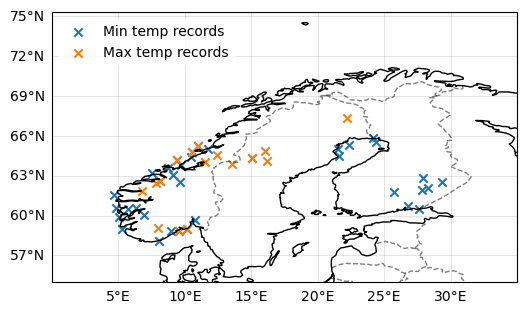

In [10]:
fig, ax = plt.subplots(figsize = (6,6), subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)}, dpi = 100)

for rt in ["min", "max"]:
    ax.scatter(sites.loc[sites.rtype == rt, "lon"], sites.loc[sites.rtype == rt, "lat"], marker = "x")

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

ax.legend(["Min temp records", "Max temp records"], loc = "upper left", edgecolor = "w")
plt.savefig("fig/record-locations.png")

# ERA5

## Maps of daily anomalies during July

In [61]:
fnm = "era5_tmax_daily_eu_extended_0-35E_55-75N_-999-lastyear.nc"

tx = wrap_lon(xr.open_dataset(fpath+fnm))
tx = tx[list(tx.data_vars)[0]]

lsm = xr.open_dataset(fpath+"era5_000000_lsm_eu.nc").lsm.squeeze(drop = True).rename(latitude = "lat", longitude = "lon").sel(lon = tx.lon, lat = tx.lat)
tx = tx.where(lsm > 0.5)

tx_clim07 = tx.groupby("time.month")[7].sel(time = slice("1990","2020")).mean("time")
anom = tx - tx_clim07

px = sites = pd.read_csv("fs-heat-records_with-coords.csv", index_col = 0)

intvl = 5

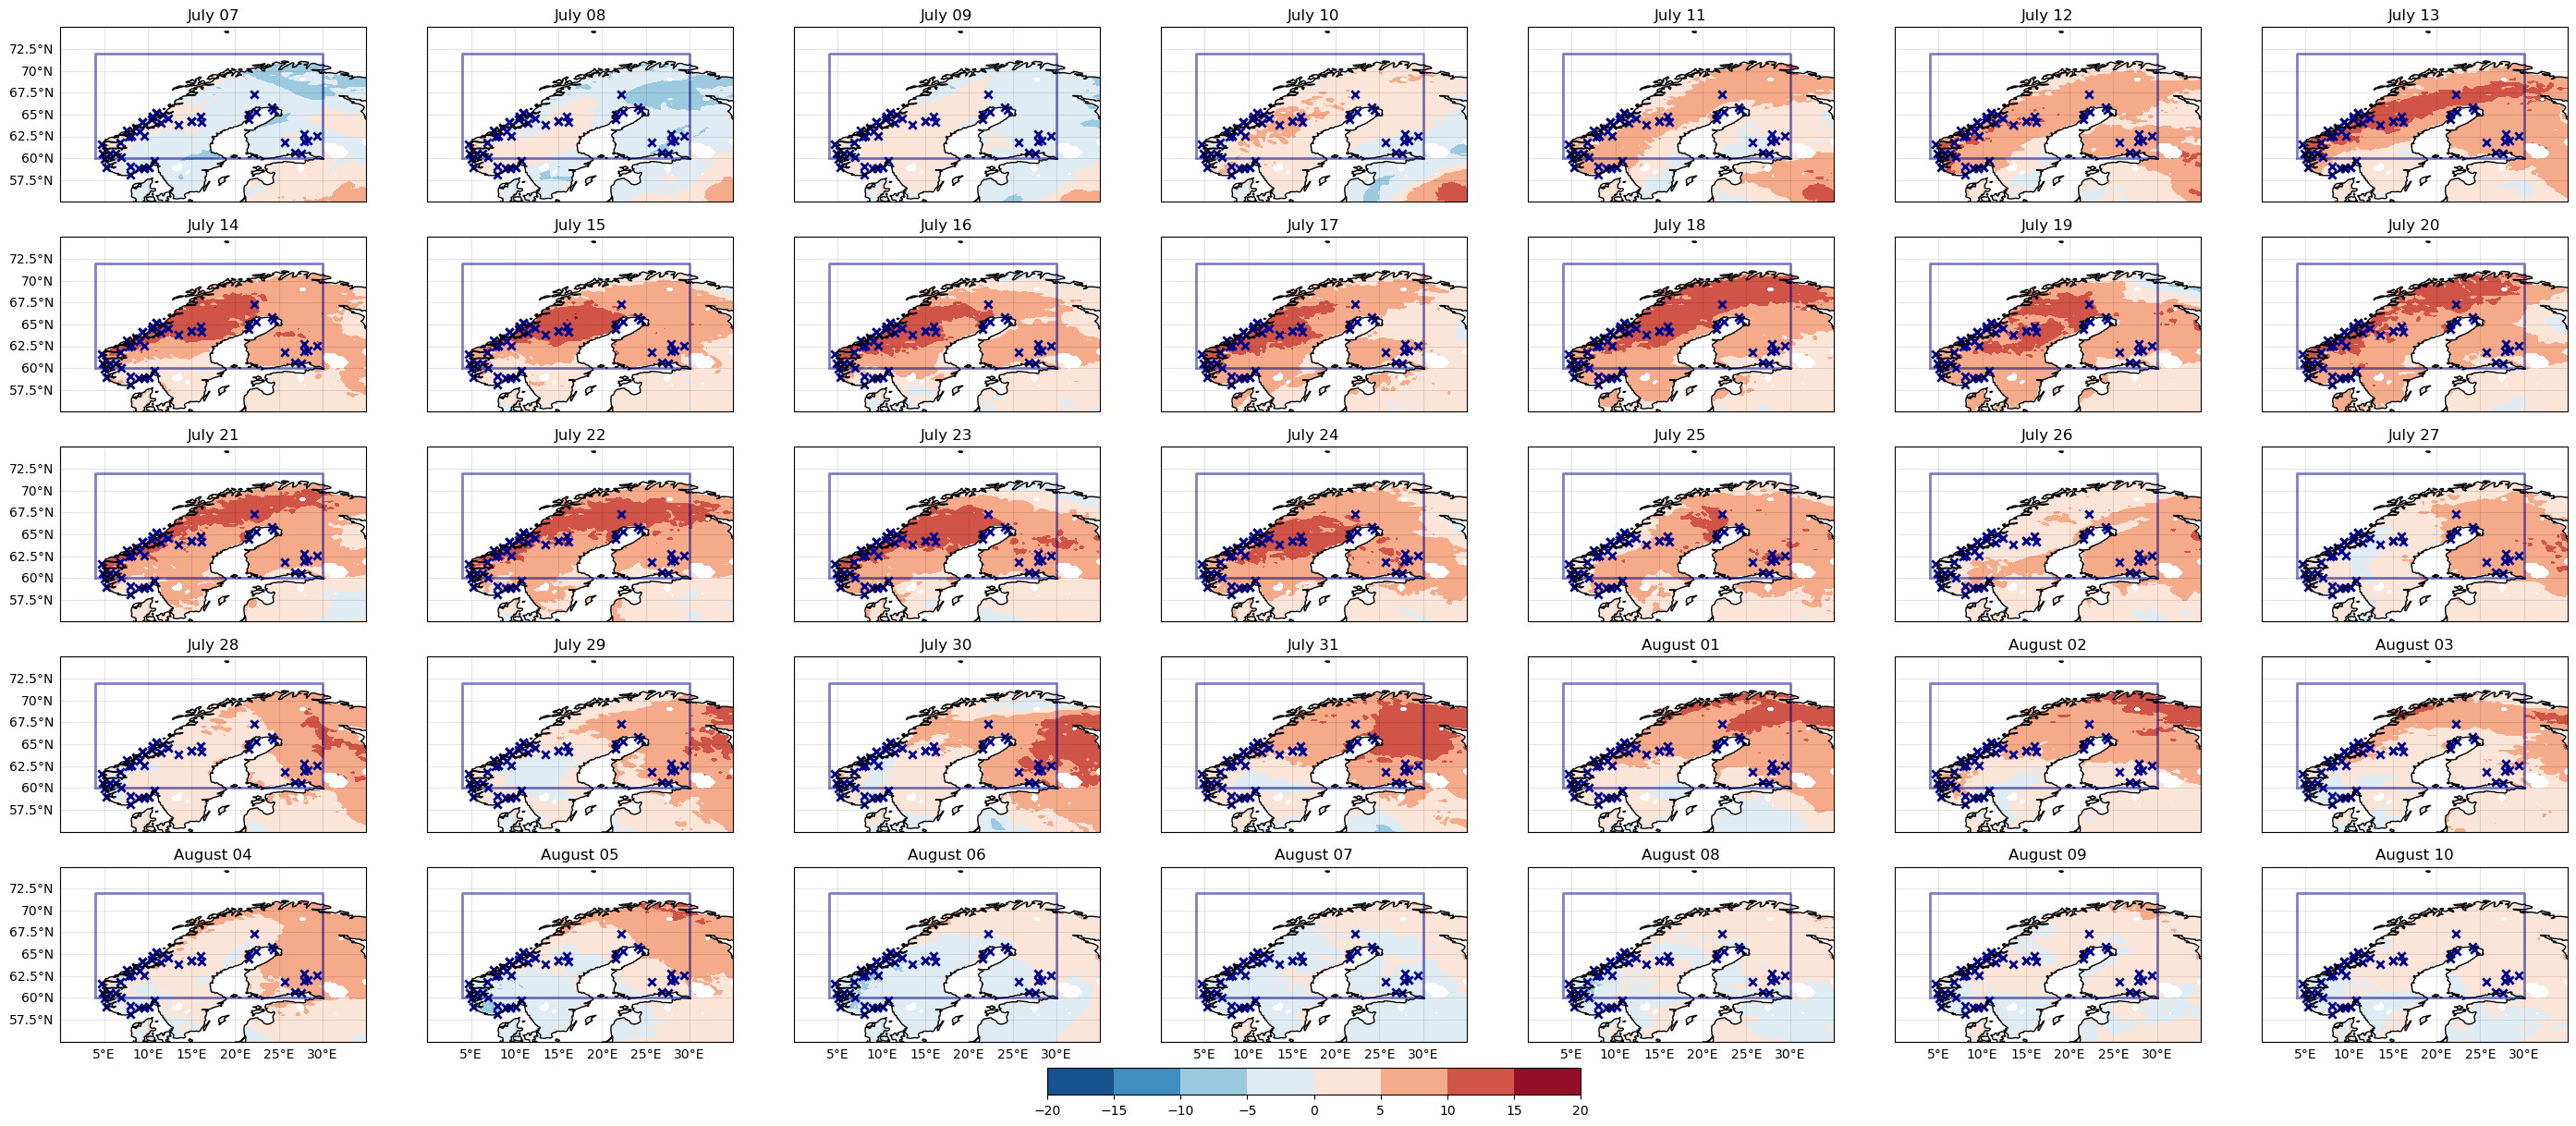

In [62]:
days = anom.sel(time = slice("2025-07-07", None)).isel(time = slice(None, -1))
nc = 7; nr = int(np.ceil(len(days)/nc))

xn,xx,yn,yx = [4,30,60,72]

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), subplot_kw = {"projection" : mapproj})

max_t = int(np.ceil(max(np.abs(days.min()), days.max()) / intvl) * intvl)
    
for i in range(len(days)):
    ax = axs.flatten()[i]
    da = days.isel(time = i)
    
    cbar = ax.contourf(da.lon, da.lat, da, levels = range(-max_t,max_t + intvl,intvl), cmap = "RdBu_r")
    ax.coastlines()
    ax.set_title(da.time.dt.strftime("%B %d").values)
    ax.gridlines(color = "k", alpha = 0.1)
    
    ax.scatter(px.lon, px.lat, marker = "x", color = "darkblue", lw = 2)
    
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)
    
for ax in axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])
for ax in axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])

for i in range(len(days), nc*nr): axs.flatten()[i].set_axis_off()

    
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.025, pad = 0.025)
plt.savefig("fig/daily-anomalies_"+"_".join(fnm.split("_")[:2]))

## Seasonal cycle / accumulations

In [63]:
fnm = "era5_tmax_daily_eu_extended_0-35E_55-75N_-999-lastyear.nc"

tx = wrap_lon(xr.open_dataset(fpath+fnm))
tx = tx[list(tx.data_vars)[0]]

lsm = xr.open_dataset(fpath+"era5_000000_lsm_eu.nc").lsm.squeeze(drop = True).rename(latitude = "lat", longitude = "lon").sel(lon = tx.lon, lat = tx.lat)
tx = tx.where(lsm > 0.5)

ts = tx.sel(lon = slice(xn,xx), lat = slice(yn,yx)).mean(["lat", "lon"])

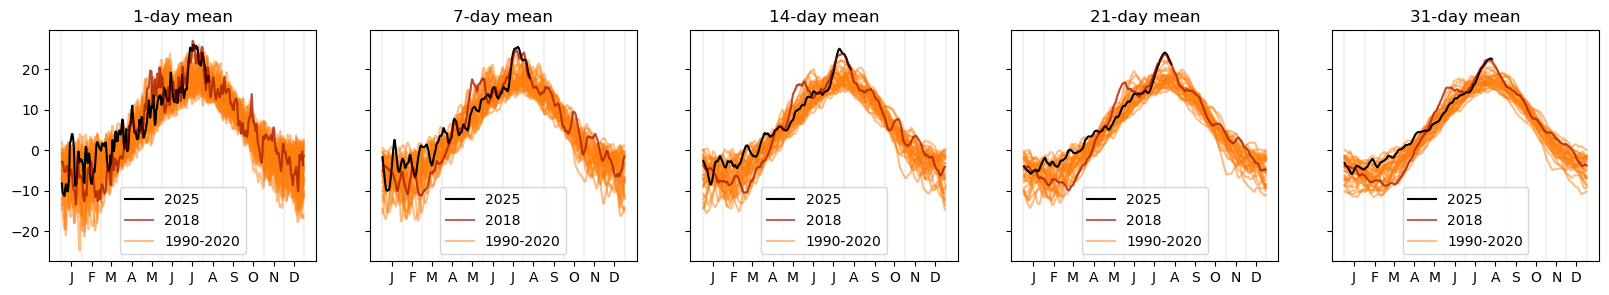

In [64]:
ndays = [1,7,14,21,31]

nc = len(ndays); nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.35)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

for i in range(nc):
    ax = axs[i]
    nd = ndays[i]
    
    ts_nday = ts.rolling(time = nd).mean()
    
    y = 2025; ts_y = ts_nday.sel(time = ts.time.dt.year == y); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    y = 2018; ts_y = ts_nday.sel(time = ts.time.dt.year == y); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", alpha = 0.6, label = "2018", zorder = 99)

    for y in range(1990,2020):
        ts_y = ts_nday.sel(time = ts.time.dt.year == y)
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")
        
    ax.set_title(str(nd)+"-day mean")

    ax.legend(["2025", "2018", "1990-2020"])
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

# ylim = ax.get_ylim()
# ax.add_patch(Rectangle((77, 0), 10, ylim[1]+10, color = "gold", alpha = 0.3))
# ax.set_ylim(ylim)

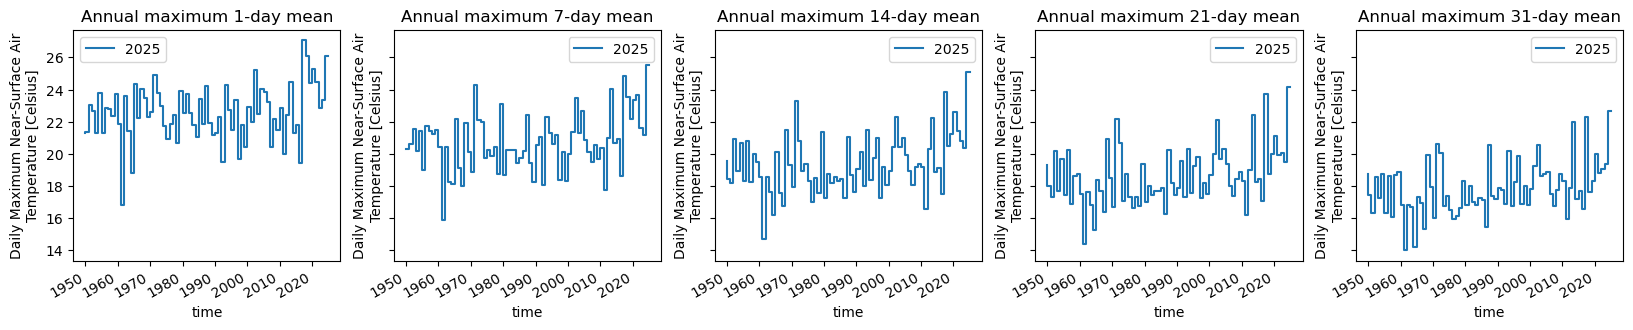

In [65]:
nc = len(ndays); nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.35)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

for i in range(nc):
    ax = axs[i]
    nd = ndays[i]
    
    txnx = ts.rolling(time = nd).mean().resample(time = "AS").max()
    txnx.plot(ax = ax, drawstyle = "steps")
        
    ax.set_title("Annual maximum "+str(nd)+"-day mean")

    ax.legend(["2025", "1990-2020"])


## Map of gridded trend

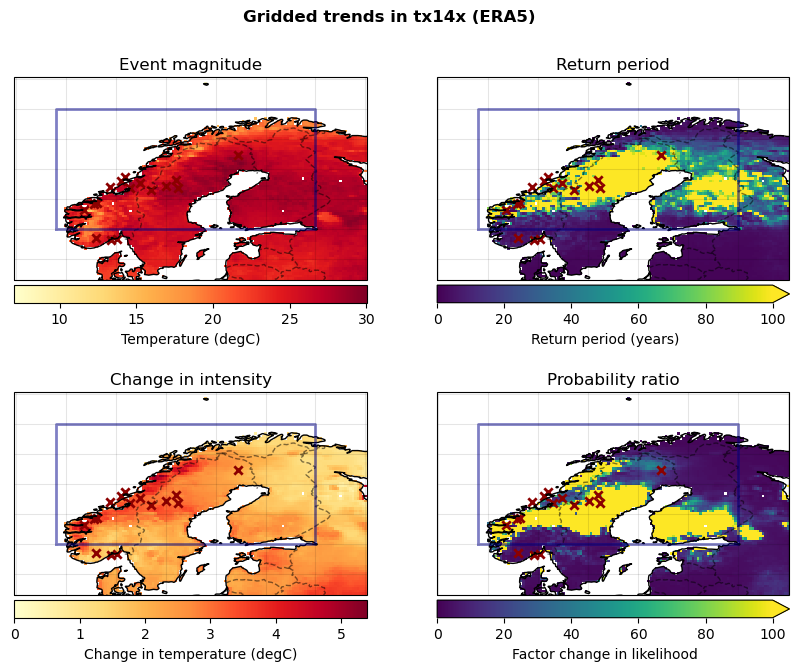

In [37]:
fnm = "gridded-trend_tx14x_era5.nc"

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# load gridded model results
res = xr.open_dataset(fnm)

# load locations of reported records
px = pd.read_csv("fs-heat-records_with-coords.csv", index_col = 0)
if "tn" in fnm:
    px = px.loc[px.rtype == "min"]
else:
    px = px.loc[px.rtype == "max"]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nr = 2; nc = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3.75), dpi = 100, subplot_kw = {"projection" : mapproj})
plt.subplots_adjust(hspace = 0.2)
axs = axs.flatten()

cbar_kwargs = {"location" : "bottom", "pad" : 0.02}

res.event_magnitude.plot(ax = axs[0], cmap = "YlOrRd", cbar_kwargs = cbar_kwargs | {"label" : "Temperature (degC)"})
axs[0].set_title("Event magnitude")

res.return_period.plot(ax = axs[1], cmap = "viridis", vmin = 0, vmax = 100, cbar_kwargs = cbar_kwargs | {"label" : "Return period (years)"})
axs[1].set_title("Return period")

res.dI_abs.plot(ax = axs[2], cmap = "YlOrRd", vmin = 0, cbar_kwargs = cbar_kwargs | {"label" : "Change in temperature (degC)"})
axs[2].set_title("Change in intensity")

res.PR.plot(ax = axs[3], cmap = "viridis", vmin = 0, vmax = 100, cbar_kwargs = cbar_kwargs | {"label" : "Factor change in likelihood"})
axs[3].set_title("Probability ratio")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1)

    ax.scatter(px.lon, px.lat, marker = "x", color = "darkred", lw = 2)
    
plt.suptitle("Gridded trends in "+fnm.split("_")[1]+" ("+fnm.split("_")[-1][:-3].upper()+")", fontweight = "bold", y = 0.95)
    
plt.savefig("fig/"+fnm[:-3]+".png")

# E-Obs

_Data currently only available until end of June so can't make daily anomaly maps_

## Map of gridded trend

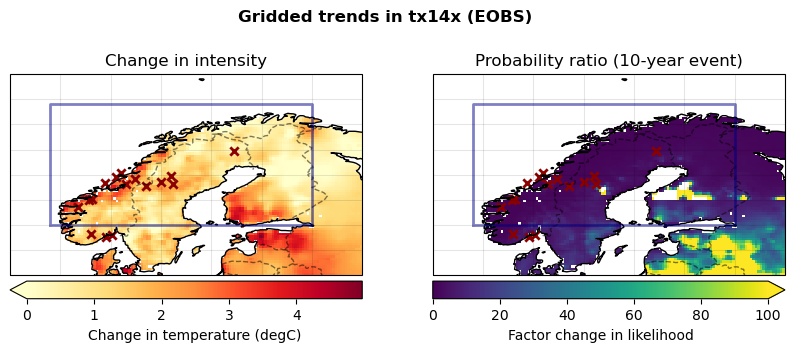

In [7]:
fnm = "gridded-trend_tx14x_eobs.nc"

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# load gridded model results
res = xr.open_dataset(fnm)

# load locations of reported records
px = pd.read_csv("fs-heat-records_with-coords.csv", index_col = 0)
if "tn" in fnm:
    px = px.loc[px.rtype == "min"]
else:
    px = px.loc[px.rtype == "max"]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nr = 1; nc = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3.75), dpi = 100, subplot_kw = {"projection" : mapproj})
plt.subplots_adjust(hspace = 0.2)
axs = axs.flatten()

cbar_kwargs = {"location" : "bottom", "pad" : 0.02}

# res.event_magnitude.plot(ax = axs[0], cmap = "YlOrRd", cbar_kwargs = cbar_kwargs | {"label" : "Temperature (degC)"})
# axs[0].set_title("Event magnitude")

# res.return_period.plot(ax = axs[1], cmap = "viridis", vmin = 0, vmax = 100, cbar_kwargs = cbar_kwargs | {"label" : "Return period (years)"})
# axs[1].set_title("Return period")

res.dI_abs.plot(ax = axs[0], cmap = "YlOrRd", vmin = 0, cbar_kwargs = cbar_kwargs | {"label" : "Change in temperature (degC)"})
axs[0].set_title("Change in intensity")

res.pr10.plot(ax = axs[1], cmap = "viridis", vmin = 0, vmax = 100, cbar_kwargs = cbar_kwargs | {"label" : "Factor change in likelihood"})
axs[1].set_title("Probability ratio (10-year event)")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1)

    ax.scatter(px.lon, px.lat, marker = "x", color = "darkred", lw = 2)
    
plt.suptitle("Gridded trends in "+fnm.split("_")[1]+" ("+fnm.split("_")[-1][:-3].upper()+")", fontweight = "bold", y = 0.95)
    
plt.savefig("fig/"+fnm[:-3]+".png")

# MSWX

In [ ]:
tx = xr.open_dataset("data/tmax_mswx.nc").tmax

lsm = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(tx.lon, tx.lat)
tx = tx.where(lsm == 0)

days = tx.sel(time = slice("2025-07", None))

intvl = 5

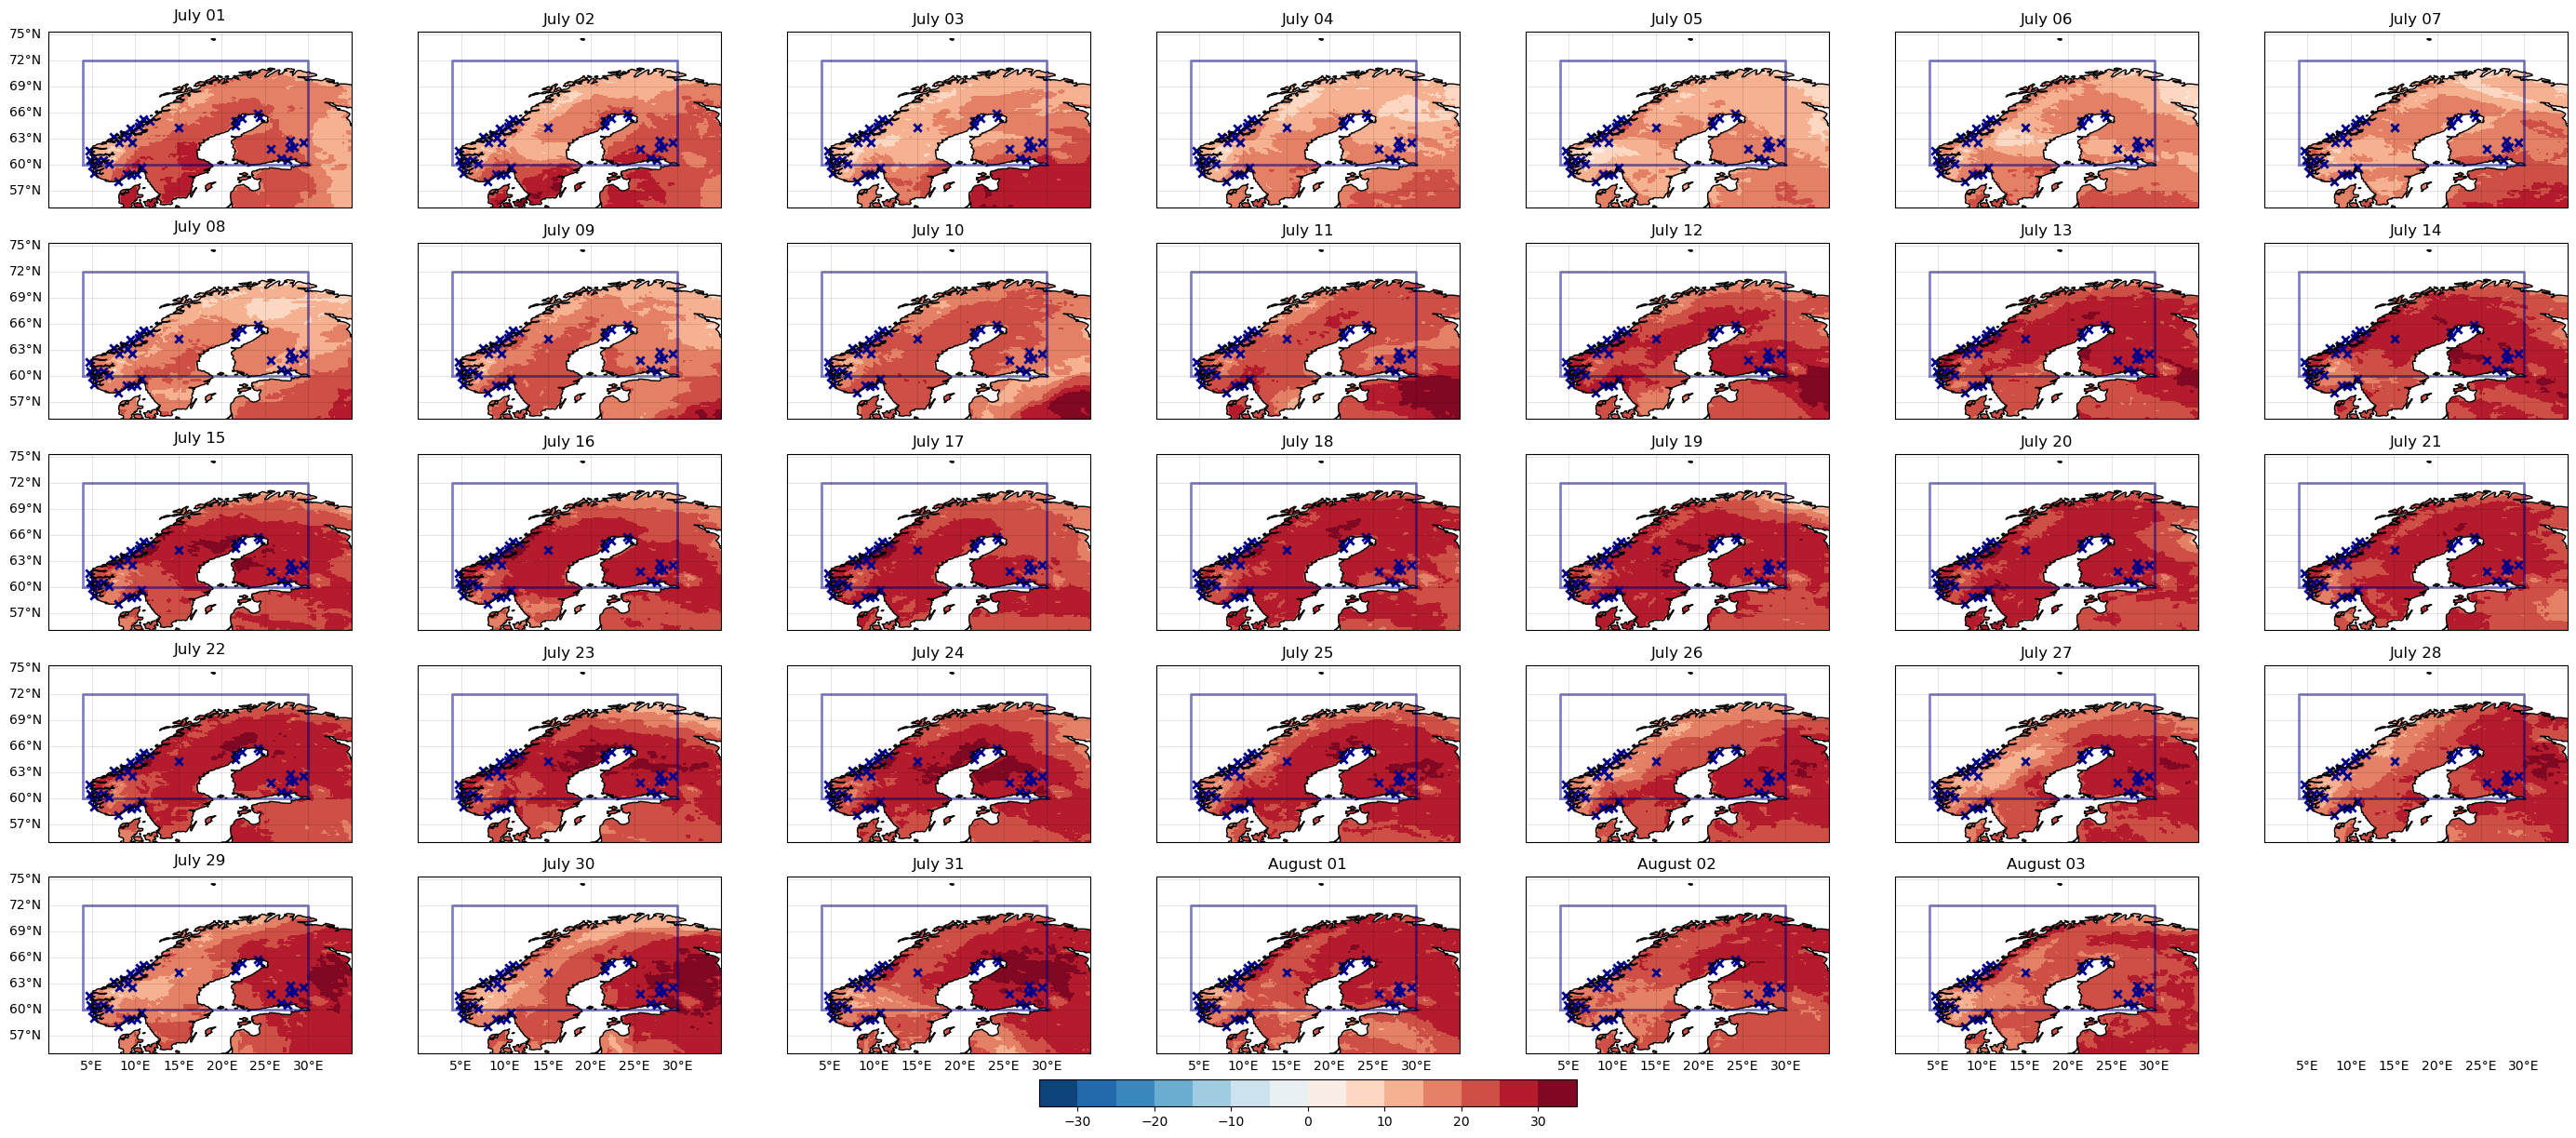

In [ ]:
nc = 7; nr = int(np.ceil(len(days)/nc))

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)}, sharex = True, sharey = True)

for i in range(len(days)):
    ax = axs.flatten()[i]
    da = days.isel(time = i)

    max_t = int(np.ceil(max(np.abs(days.min()), days.max()) / intvl) * intvl)
    
    cbar = ax.contourf(da.lon, da.lat, da, levels = range(-max_t,max_t + intvl,intvl), cmap = "RdBu_r")
    ax.coastlines()
    ax.set_title(da.time.dt.strftime("%B %d").values)
    ax.gridlines(color = "k", alpha = 0.1)
    
    ax.scatter(px.lon, px.lat, marker = "x", color = "darkblue", lw = 2)
    
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)
    
for ax in axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])
for ax in axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])

for i in range(len(days), nc*nr): axs.flatten()[i].set_axis_off()

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.025, pad = 0.025)

# Time series for analysis

In [4]:
ndays = 14

tx_list = {"era5" : "era5_tmax_daily_land_0-35E_55-75N.nc",
           "eobs" : "eobs_tx_0.25deg.nc",
           "cpc" : "tmax_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc"}

tn_list = {"era5" : "era5_tmin_daily_land_0-35E_55-75N.nc",
           "eobs" : "eobs_tn_0.25deg.nc",
           "cpc" : "tmin_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc"}

In [5]:
for varnm in ["tx", "tn"]:

    ds_list = eval(varnm+"_list")
    
    for ds_nm, fnm in ds_list.items():

        print(fnm)
    
        da = wrap_lon(xr.open_dataset(fpath+fnm))
        da = da[list(da.data_vars)[0]]
        
        if "longitude" in da.dims:
            da = da.rename(longitude = "lon", latitude = "lat")
        
        ts = da.sel(lon = slice(xn,xx), lat = slice(yn,yx)).mean(["lat", "lon"])
        txnx = ts.rolling(time = ndays, center = False).mean().resample(time = "AS").max()
        txnx.assign_coords(time = txnx.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/"+varnm+str(ndays)+"x_"+ds_nm+".csv")

era5_tmax_daily_land_0-35E_55-75N.nc
eobs_tx_0.25deg.nc
tmax_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc
era5_tmin_daily_land_0-35E_55-75N.nc
eobs_tn_0.25deg.nc
tmin_cpc_daily_0-35E_55-75N_-999-lastyear_su.nc
